# 第十一章 训练深度神经网络

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## 11.1 梯度消失与梯度爆炸问题

Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


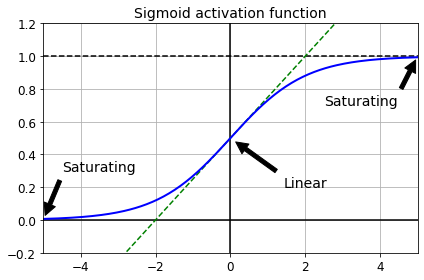

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

### 11.1.1 Glorot和He初始化

Glorot and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### 11.1.2 非饱和激活函数

Nonsaturating Activation Functions

Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


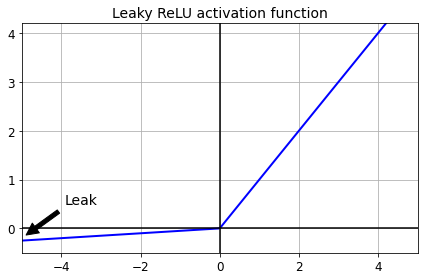

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 931us/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 1s 868us/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7896
Epoch 4/10
1719/1719 [==============================] - 2s 895us/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 1s 865us/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 1s 868us/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val

Now let's try PReLU:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 962us/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 1s 849us/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 2s 925us/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 1s 868us/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 1s 868us/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 1s 859us/step - loss: 0.5618 - accuracy: 0.8134 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 1s 868us/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 -

ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


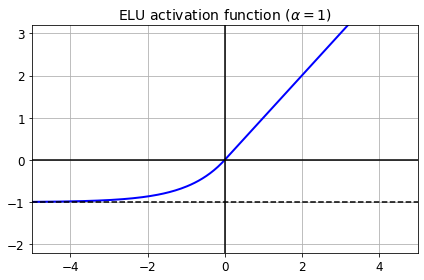

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


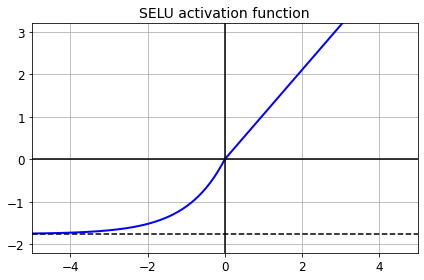

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.2227 - accuracy: 0.5223 - val_loss: 1.1508 - val_accuracy: 0.5512
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7246 - accuracy: 0.7358 - val_loss: 0.6233 - val_accuracy: 0.7744
Epoch 3/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6128 - accuracy: 0.7793 - val_loss: 0.5605 - val_accuracy: 0.8036
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5473 - accuracy: 0.8078 - val_loss: 0.5126 - val_accuracy: 0.8232
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5083 - accuracy: 0.8249 - val_loss: 0.5157 - val_accuracy: 0.8202


Now look at what happens if we try to use the ReLU activation function instead:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 11s 6ms/step - loss: 1.8087 - accuracy: 0.2619 - val_loss: 1.2504 - val_accuracy: 0.4508
Epoch 2/5
1719/1719 [==============================] - 11s 6ms/step - loss: 1.1578 - accuracy: 0.5063 - val_loss: 1.0446 - val_accuracy: 0.5696
Epoch 3/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.8986 - accuracy: 0.6410 - val_loss: 1.5645 - val_accuracy: 0.4182
Epoch 4/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8338 - accuracy: 0.6696 - val_loss: 0.7262 - val_accuracy: 0.7350
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8037 - accuracy: 0.6853 - val_loss: 0.7714 - val_accuracy: 0.6890


Not great at all, we suffered from the vanishing/exploding gradients problem.

### 11.1.3 批量归一化

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
#bn1.updates #deprecated

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5753 - accuracy: 0.8030 - val_loss: 0.4725 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5189 - accuracy: 0.8205 - val_loss: 0.4375 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4827 - accuracy: 0.8326 - val_loss: 0.4152 - val_accuracy: 0.8604
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4565 - accuracy: 0.8408 - val_loss: 0.3996 - val_accuracy: 0.8636
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4397 - accuracy: 0.8475 - val_loss: 0.3866 - val_accuracy: 0.8696
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4242 - accuracy: 0.8514 - val_loss: 0.3762 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0317 - accuracy: 0.6756 - val_loss: 0.6767 - val_accuracy: 0.7810
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8182
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5447 - accuracy: 0.8191 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.4434 - val_accuracy: 0.8532
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4898 - accuracy: 0.8336 - val_loss: 0.4263 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4712 - accuracy: 0.8397 - val_loss: 0.4130 - val_accuracy:

### 11.1.4 梯度裁剪

Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 11.2 重用预训练层

Reusing Pretrained Layers

### 11.2.1 用Keras进行迁移学习

Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 1s 996us/step - loss: 0.5927 - accuracy: 0.8103 - val_loss: 0.3892 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 1s 894us/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3287 - val_accuracy: 0.8829
Epoch 3/20
1375/1375 [==============================] - 1s 871us/step - loss: 0.3170 - accuracy: 0.8894 - val_loss: 0.3011 - val_accuracy: 0.8979
Epoch 4/20
1375/1375 [==============================] - 1s 875us/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2893 - val_accuracy: 0.9018
Epoch 5/20
1375/1375 [==============================] - 1s 854us/step - loss: 0.2835 - accuracy: 0.9019 - val_loss: 0.2774 - val_accuracy: 0.9071
Epoch 6/20
1375/1375 [==============================] - 1s 843us/step - loss: 0.2730 - accuracy: 0.9059 - val_loss: 0.2735 - val_accuracy: 0.9061
Epoch 7/20
1375/1375 [==============================] - 1s 855us/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2720 -

In [55]:
model_A.save("my_model_A.h5")

In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [=================

In [59]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_225 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_226 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_227 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_228 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

In [60]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 19ms/step - loss: 0.5785 - accuracy: 0.6500 - val_loss: 0.5829 - val_accuracy: 0.6359
Epoch 2/4
7/7 [==============================] - 0s 5ms/step - loss: 0.5421 - accuracy: 0.6700 - val_loss: 0.5455 - val_accuracy: 0.6785
Epoch 3/4
7/7 [==============================] - 0s 5ms/step - loss: 0.5054 - accuracy: 0.7250 - val_loss: 0.5135 - val_accuracy: 0.7069
Epoch 4/4
7/7 [==============================] - 0s 5ms/step - loss: 0.4739 - accuracy: 0.7500 - val_loss: 0.4849 - val_accuracy: 0.7333
Epoch 1/16
7/7 [==============================] - 0s 18ms/step - loss: 0.3956 - accuracy: 0.8200 - val_loss: 0.3457 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 5ms/step - loss: 0.2797 - accuracy: 0.9350 - val_loss: 0.2603 - val_accuracy: 0.9290
Epoch 3/16
7/7 [==============================] - 0s 5ms/step - loss: 0.2083 - accuracy: 0.9650 - val_loss: 0.2111 - val_accuracy: 0.9554
Epoch 4/16
7/7 [====================

In [64]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 524us/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407986164093, 0.9704999923706055]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 540us/step - loss: 0.0684 - accuracy: 0.9935


[0.06837236881256104, 0.9934999942779541]

In [66]:
(100 - 97.05) / (100 - 99.35)

4.538461538461503

## 11.3 更快的优化器

Faster Optimizers

### 11.3.1 动量优化

Momentum optimization

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### 11.3.2 Nesterov加速梯度

In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad

In [69]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### 11.3.4 RMSProp

In [70]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### 11.3.5 Adam和Nadam优化

In [71]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

### 11.3.6 学习率调度

冥调度 Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [72]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [73]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [74]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4855 - accuracy: 0.8303 - val_loss: 0.4031 - val_accuracy: 0.8600
Epoch 2/25
1719/1719 [==============================] - 1s 854us/step - loss: 0.3781 - accuracy: 0.8653 - val_loss: 0.3714 - val_accuracy: 0.8722
Epoch 3/25
1719/1719 [==============================] - 2s 961us/step - loss: 0.3458 - accuracy: 0.8770 - val_loss: 0.3746 - val_accuracy: 0.8746
Epoch 4/25
1719/1719 [==============================] - 2s 907us/step - loss: 0.3250 - accuracy: 0.8830 - val_loss: 0.3501 - val_accuracy: 0.8788
Epoch 5/25
1719/1719 [==============================] - 2s 882us/step - loss: 0.3102 - accuracy: 0.8891 - val_loss: 0.3446 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 2s 956us/step - loss: 0.2966 - accuracy: 0.8931 - val_loss: 0.3415 - val_accuracy: 0.8826
Epoch 7/25
1719/1719 [==============================] - 2s 998us/step - loss: 0.2868 - accuracy: 0.8974 - val_loss: 0.3357 - v

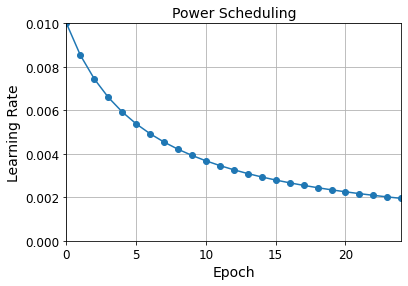

In [75]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

指数调度 Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [76]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [77]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [78]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [79]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8501 - accuracy: 0.7572 - val_loss: 0.7910 - val_accuracy: 0.7200
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7345 - accuracy: 0.7896 - val_loss: 0.6148 - val_accuracy: 0.8160
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6852 - accuracy: 0.8075 - val_loss: 0.7310 - val_accuracy: 0.8010
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5650 - accuracy: 0.8362 - val_loss: 0.5209 - val_accuracy: 0.8458
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5427 - accuracy: 0.8408 - val_loss: 0.5339 - val_accuracy: 0.8468
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4877 - accuracy: 0.8564 - val_loss: 0.5077 - val_accuracy: 0.8522
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4481 - accuracy: 0.8658 - val_loss: 0.5480 - val_accuracy:

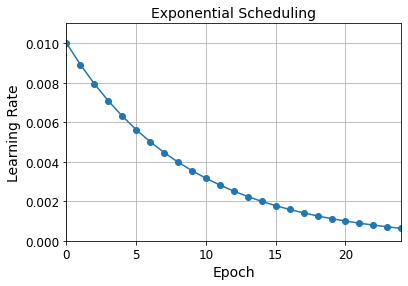

In [80]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [81]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [82]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7934 - accuracy: 0.7671 - val_loss: 0.7332 - val_accuracy: 0.7610
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6780 - accuracy: 0.7945 - val_loss: 0.6667 - val_accuracy: 0.7866
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5905 - accuracy: 0.8167 - val_loss: 0.6033 - val_accuracy: 0.8320
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5075 - accuracy: 0.8412 - val_loss: 0.4512 - val_accuracy: 0.8644
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4620 - accuracy: 0.8549 - val_loss: 0.4685 - val_accuracy: 0.8556
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4236 - accuracy: 0.8653 - val_loss: 0.4659 - val_accuracy: 0.8674
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4027 - accuracy: 0.8711 - val_loss: 0.4785 - val_accuracy:

In [83]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

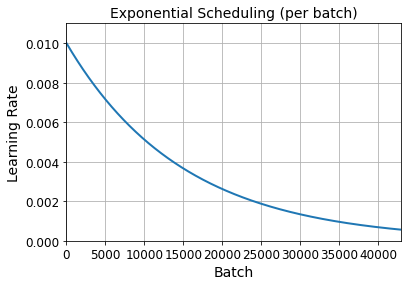

In [84]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

 Piecewise Constant Scheduling

In [85]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [86]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [87]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8539 - accuracy: 0.7571 - val_loss: 1.0519 - val_accuracy: 0.6574
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0013 - accuracy: 0.7167 - val_loss: 1.0102 - val_accuracy: 0.6750
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8781 - accuracy: 0.7293 - val_loss: 1.0961 - val_accuracy: 0.6936
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.9999 - accuracy: 0.6876 - val_loss: 1.0778 - val_accuracy: 0.6766
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.9905 - accuracy: 0.7052 - val_loss: 1.3318 - val_accuracy: 0.6798
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6121 - accuracy: 0.8167 - val_loss: 0.6502 - val_accuracy: 0.8320
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5542 - accuracy: 0.8349 - val_loss: 0.5860 - val_accuracy:

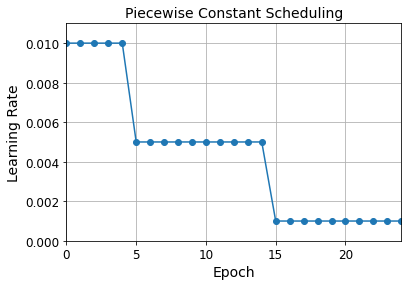

In [88]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Performance Scheduling

In [89]:
tf.random.set_seed(42)
np.random.seed(42)

In [90]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 1s 837us/step - loss: 0.5947 - accuracy: 0.8057 - val_loss: 0.4706 - val_accuracy: 0.8540
Epoch 2/25
1719/1719 [==============================] - 1s 773us/step - loss: 0.4986 - accuracy: 0.8392 - val_loss: 0.5999 - val_accuracy: 0.8256
Epoch 3/25
1719/1719 [==============================] - 1s 779us/step - loss: 0.5127 - accuracy: 0.8425 - val_loss: 0.5642 - val_accuracy: 0.8452
Epoch 4/25
1719/1719 [==============================] - 1s 841us/step - loss: 0.5158 - accuracy: 0.8456 - val_loss: 0.4671 - val_accuracy: 0.8562
Epoch 5/25
1719/1719 [==============================] - 2s 887us/step - loss: 0.5417 - accuracy: 0.8447 - val_loss: 0.5452 - val_accuracy: 0.8384
Epoch 6/25
1719/1719 [==============================] - 1s 871us/step - loss: 0.5145 - accuracy: 0.8509 - val_loss: 0.6106 - val_accuracy: 0.8454
Epoch 7/25
1719/1719 [==============================] - 1s 780us/step - loss: 0.5587 - accuracy: 0.8488 - val_loss: 0.6265 -

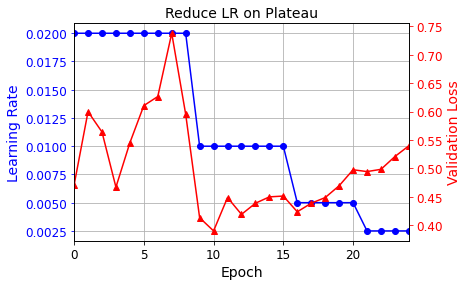

In [91]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

tf.keras schedulers

In [92]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 1s 763us/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 1s 694us/step - loss: 0.3820 - accuracy: 0.8651 - val_loss: 0.3739 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 1s 701us/step - loss: 0.3487 - accuracy: 0.8765 - val_loss: 0.3734 - val_accuracy: 0.8684
Epoch 4/25
1719/1719 [==============================] - 1s 723us/step - loss: 0.3264 - accuracy: 0.8838 - val_loss: 0.3492 - val_accuracy: 0.8800
Epoch 5/25
1719/1719 [==============================] - 1s 756us/step - loss: 0.3104 - accuracy: 0.8897 - val_loss: 0.3430 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 1s 713us/step - loss: 0.2958 - accuracy: 0.8954 - val_loss: 0.3415 - val_accuracy: 0.8808
Epoch 7/25
1719/1719 [==============================] - 1s 702us/step - loss: 0.2854 - accuracy: 0.8987 - val_loss: 0.3356 -

In [93]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

1Cycle scheduling

In [94]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
```

In [95]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 1ms/step - loss: 7230127879999193088.0000 - accuracy: 0.3852


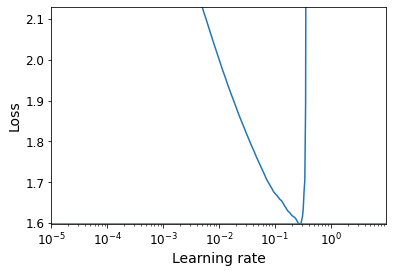

In [96]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [97]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [98]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4122 - accuracy: 0.8545 - val_loss: 0.4115 - val_accuracy: 0.8580
Epoch 4/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3867 - val_accuracy: 0.8686
Epoch 5/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3639 - accuracy: 0.8718 - val_loss: 0.3765 - val_accuracy: 0.8688
Epoch 6/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3456 - accuracy: 0.8775 - val_loss: 0.3745 - val_accuracy: 0.8710
Epoch 7/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3636 - val_accuracy: 0.8712
Epoch 

## 11.4 过正则化避免过拟合

### 11.4.1 $\ell_1$ and $\ell_2$ regularization

In [99]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [100]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 2s 1ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [101]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 2ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


### 11.4.2 dropout

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5838 - accuracy: 0.7997 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4209 - accuracy: 0.8442 - val_loss: 0.3395 - val_accuracy: 0.8720


### Alpha Dropout

In [103]:
tf.random.set_seed(42)
np.random.seed(42)

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6654 - accuracy: 0.7599 - val_loss: 0.5935 - val_accuracy: 0.8410
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5605 - accuracy: 0.7934 - val_loss: 0.5593 - val_accuracy: 0.8394
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5281 - accuracy: 0.8044 - val_loss: 0.4816 - val_accuracy: 0.8592
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5072 - accuracy: 0.8126 - val_loss: 0.4618 - val_accuracy: 0.8584
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4921 - accuracy: 0.8181 - val_loss: 0.4607 - val_accuracy: 0.8572
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4868 - accuracy: 0.8192 - val_loss: 0.4695 - val_accuracy: 0.8616
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4719 - accuracy: 0.8252 - val_loss: 0.4624 - val_accuracy:

In [105]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 514us/step - loss: 0.4419 - accuracy: 0.8698


[0.4419400990009308, 0.8697999715805054]

In [106]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 1s 523us/step - loss: 0.3264 - accuracy: 0.8897


[0.3263794481754303, 0.8897091150283813]

In [107]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 1ms/step - loss: 0.4163 - accuracy: 0.8459
